<h1>Optical Character Recognition - Street View House Number</h1>
<br>
<b>Context:</b>
<p>Recognizing multi-digit numbers in photographs captured at street level is an important component of modern-day map making. A classic example of a corpus of such street level photographs is Google’s Street View imagery comprised of hundreds of millions of geo-located 360 degree panoramic images. The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents.</p>
<p>More broadly, recognizing numbers in photographs is a problem of interest to the optical character recognition community. While OCR on constrained domains like document processing is well studied, arbitrary multi-character text recognition in photographs is still highly challenging. This difficulty arises due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts, colors, styles, orientations, and character arrangements. The recognition problem is further complicated by environmental factors such as lighting, shadows, specularities, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs.</p>
<p>This is a multi-class classification problem with 10 classes, one for each digit 0-9. Digit '1' has label 1, '9' has label 9 and '0' has label 10.</p>
<br>
<b>Objective:</b>
<p>This project deals with images centred around a single digit (many of the images do contain some distractors at the sides). We want to compare the performance of a simple KNN model, a highly optimized neural network, and a simple convolutional neural network, and finally, a convolutional model using transfer learning using the weights of a model that was previously trained with the MNIST dataset.</p>


<h3>Importing Dependencies</h3>

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from skimage.transform import resize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.utils import normalize
from keras.callbacks.callbacks import EarlyStopping
from keras import regularizers
from keras import optimizers

<h3>Split data into training, validation, and test set</h3>

In [98]:
dataset = h5py.File('SVHN_single_grey1.h5','r')
print(dataset.keys())

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>


In [99]:
X_train = np.array(dataset['X_train'])
X_val = np.array(dataset['X_val'])
X_test = np.array(dataset['X_test'])
y_train = np.array(dataset['y_train'])
y_val = np.array(dataset['y_val'])
y_test = np.array(dataset['y_test'])

In [100]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)
print("y_val:", y_val.shape)

X_train: (42000, 32, 32)
X_test: (18000, 32, 32)
X_val: (60000, 32, 32)
y_train: (42000,)
y_test: (18000,)
y_val: (60000,)


<h3>Visualizing the data</h3>

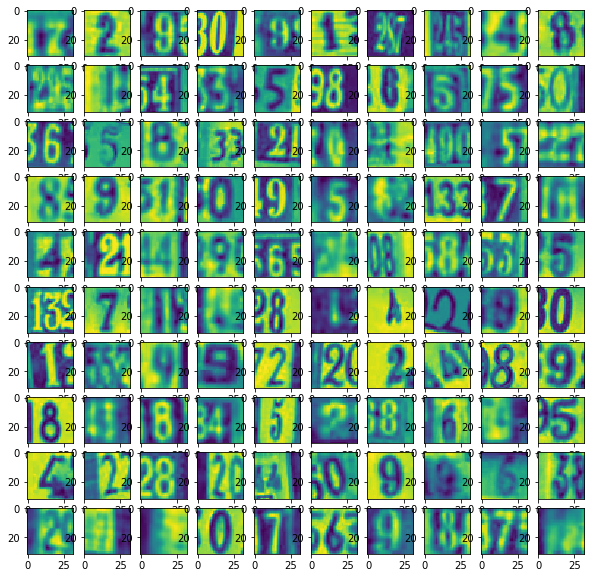

In [5]:
fig = plt.figure(figsize=(10,10))
rows=10
cols=10
for i in range(1, rows*cols + 1):
    img = X_test[i]
    fig.add_subplot(rows,cols, i)
    plt.imshow(img)
plt.show()

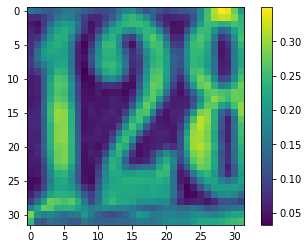

In [7]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()

<h3>Normalizing the image data</h3>

In [101]:
X_train = normalize(X_train, axis=-1, order=2)
X_test = normalize(X_test, axis=-1, order=2)
X_val = normalize(X_val, axis=-1, order=2)

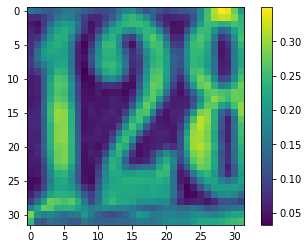

In [60]:
plt.figure()
plt.imshow(X_train[0])
plt.colorbar()

In [12]:
class_labels = [1,2,3,4,5,6,7,8,9,0]

<h2>Using K Nearest Neighbours Classifier</h2>

In [10]:
X_train_knn = X_train.reshape((42000,1024))

In [11]:
X_test_knn = X_test.reshape((18000,1024))

In [12]:
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', n_jobs=-1)
knn.fit(X_train_knn, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=10, p=2,
                     weights='distance')

In [14]:
pred = knn.predict(X_test_knn)

In [15]:
knn.score(X_test_knn, y_test)

0.6186666666666667

In [25]:
print(confusion_matrix(y_test, pred, labels=class_labels))

[[1415   31   59   86   29   34   53   26   30   65]
 [ 135 1082   82   55   31   32  177   55  102   52]
 [ 202   70  897   63  150   42   71   88   73   63]
 [ 194   29   52 1292   24   50   25   40   40   66]
 [ 101   43  191   52  882  158   29  134   89   89]
 [  79   28   53   95   80  997   20  234   45  201]
 [ 162   87   49   30   20   40 1302   27   38   53]
 [  81   26   95   80   87  215   32  944  102  150]
 [  98   53   92   53   67   61   51  112  998  219]
 [  52   21   35   38   34   91   30   82  104 1327]]


In [35]:
f1_score(y_test, pred, average='weighted')

0.6166228268481216

<h4>Using K Nearest Neighbors, we get an accuracy score of 61%</h4>

<hr>

<h2>Using Neural Networks</h2>

In [13]:
optima = optimizers.Adam(learning_rate=0.001)
monitor = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto', restore_best_weights=True)

Instructions for updating:
Colocations handled automatically by placer.


In [81]:
model = Sequential()
model.add(Flatten(input_shape=(32, 32)))
model.add(Dense(512, activation='relu', activity_regularizer= regularizers.l2(0.01)))
model.add(BatchNormalization(axis=1))
model.add(Dense(256, activation='relu', activity_regularizer= regularizers.l2(0.01)))
model.add(BatchNormalization(axis=1))
model.add(Dense(128, activation='relu', activity_regularizer= regularizers.l2(0.01)))
model.add(BatchNormalization(axis=1))
model.add(Dense(64, activation='relu', activity_regularizer= regularizers.l2(0.01)))
model.add(BatchNormalization(axis=1))
model.add(Dense(32, activation='relu', activity_regularizer= regularizers.l2(0.01)))
model.add(BatchNormalization(axis=1))
model.add(Dense(10, activation='softmax'))

In [82]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_15 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_90 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_v1_75 (B (None, 512)               2048      
_________________________________________________________________
dense_91 (Dense)             (None, 256)               131328    
_________________________________________________________________
batch_normalization_v1_76 (B (None, 256)               1024      
_________________________________________________________________
dense_92 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_v1_77 (B (None, 128)               512       
__________

In [83]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [84]:
model.fit(X_train, y_train, batch_size=500, epochs=200, verbose=1, validation_data=(X_val,y_val), callbacks=[monitor])

Train on 42000 samples, validate on 60000 samples
Epoch 1/200
42000/42000 [==============================] - 4s 94us/sample - loss: 3.1732 - acc: 0.4423 - val_loss: 2.4200 - val_acc: 0.1000
Epoch 2/200
42000/42000 [==============================] - 2s 48us/sample - loss: 1.9708 - acc: 0.6235 - val_loss: 2.4409 - val_acc: 0.1150
Epoch 3/200
42000/42000 [==============================] - 2s 49us/sample - loss: 1.5385 - acc: 0.6784 - val_loss: 2.4475 - val_acc: 0.1170
Epoch 4/200
42000/42000 [==============================] - 2s 52us/sample - loss: 1.3024 - acc: 0.7100 - val_loss: 2.4317 - val_acc: 0.1789
Epoch 5/200
42000/42000 [==============================] - 2s 46us/sample - loss: 1.1556 - acc: 0.7336 - val_loss: 2.0111 - val_acc: 0.3585
Epoch 6/200
42000/42000 [==============================] - 2s 46us/sample - loss: 1.0781 - acc: 0.7462 - val_loss: 2.2151 - val_acc: 0.3225
Epoch 7/200
42000/42000 [==============================] - 2s 45us/sample - loss: 0.9869 - acc: 0.7672 - val_l

Epoch 59/200
42000/42000 [==============================] - 2s 42us/sample - loss: 0.3352 - acc: 0.9219 - val_loss: 1.2175 - val_acc: 0.6919
Epoch 60/200
42000/42000 [==============================] - 2s 47us/sample - loss: 0.3372 - acc: 0.9225 - val_loss: 1.5909 - val_acc: 0.6421
Epoch 61/200
42000/42000 [==============================] - 2s 46us/sample - loss: 0.3378 - acc: 0.9215 - val_loss: 1.3284 - val_acc: 0.6736
Epoch 62/200
42000/42000 [==============================] - 2s 41us/sample - loss: 0.3344 - acc: 0.9217 - val_loss: 1.9582 - val_acc: 0.5681
Epoch 63/200
42000/42000 [==============================] - 2s 41us/sample - loss: 0.3287 - acc: 0.9253 - val_loss: 1.2710 - val_acc: 0.6934
Epoch 64/200
42000/42000 [==============================] - 2s 45us/sample - loss: 0.3266 - acc: 0.9232 - val_loss: 1.8359 - val_acc: 0.5842
Epoch 65/200
42000/42000 [==============================] - 2s 46us/sample - loss: 0.3248 - acc: 0.9260 - val_loss: 1.3051 - val_acc: 0.6797
Epoch 66/200


In [86]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

18000/18000 [==============================] - 2s 129us/sample - loss: 1.3664 - acc: 0.6804


In [87]:
pred = model.predict(X_test)

In [88]:
pred[3]

array([3.7661837e-06, 6.8613474e-07, 4.4693456e-06, 1.6092706e-07,
       6.9168698e-07, 2.1821366e-05, 1.2026867e-06, 1.8447149e-06,
       7.9431993e-06, 9.9995732e-01], dtype=float32)

In [89]:
np.argmax(pred[3])

9

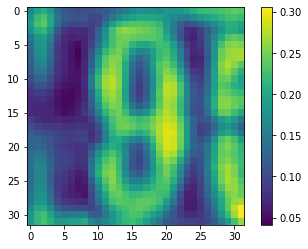

In [90]:
plt.figure()
plt.imshow(X_test[3])
plt.colorbar()

<h4>Using Neural Networks, we get an accuracy score of 90% in Training and 68% in test set</h4>

<hr>

<h2>Using Convolutional Neural Network</h2>

In [6]:
# The validation set has more images than the train set. Therefore reducing it.
X_val = X_val[0:12000]
y_val = y_val[0:12000]
X_val.shape

(12000, 32, 32)

In [76]:
X_train = X_train.reshape(42000, 32, 32, 1)
print(X_train.shape)
X_test = X_test.reshape(18000, 32, 32, 1)
X_val = X_val.reshape(12000, 32, 32, 1)

(42000, 32, 32, 1)


In [77]:
ConvModel = Sequential([
    Conv2D(filters=32, kernel_size = (3,3), activation = 'relu', input_shape = (32,32,1)),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate = 0.25),
    Flatten(),
    Dense(512, activation='relu', activity_regularizer= regularizers.l2(0.01)),
    BatchNormalization(axis=1),
    Dropout(rate = 0.25),
    Dense(128, activation='relu', activity_regularizer= regularizers.l2(0.01)),
    BatchNormalization(axis=1),
    Dropout(rate = 0.25),
    Dense(10, activation='softmax')
])

In [78]:
ConvModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 512)               6423040   
_________________________________________________________________
batch_normalization_v1_12 (B (None, 512)               2048      
__________

In [79]:
ConvModel.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [82]:
ConvModel.fit(X_train, y_train, batch_size=500, epochs=200, verbose=1, validation_data=(X_val,y_val), callbacks=[monitor])

Train on 42000 samples, validate on 12000 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
42000/42000 [==============================] - 10s 246us/sample - loss: 1.1777 - acc: 0.6389 - val_loss: 2.4213 - val_acc: 0.0000e+00
Epoch 2/200
42000/42000 [==============================] - 7s 164us/sample - loss: 0.6087 - acc: 0.8159 - val_loss: 2.5514 - val_acc: 0.0000e+00
Epoch 3/200
42000/42000 [==============================] - 7s 164us/sample - loss: 0.5299 - acc: 0.8410 - val_loss: 2.6302 - val_acc: 0.0000e+00
Epoch 4/200
42000/42000 [==============================] - 7s 164us/sample - loss: 0.4722 - acc: 0.8582 - val_loss: 2.6062 - val_acc: 0.0000e+00
Epoch 5/200
42000/42000 [==============================] - 7s 166us/sample - loss: 0.4334 - acc: 0.8700 - val_loss: 2.5386 - val_acc: 0.0028
Epoch 6/200
42000/42000 [==============================] - 7s 171us/sample - loss: 0.4017 - acc: 0.8799 - val_loss: 1.7845 - val_acc: 0.3517
Epoch 7/200
42000/42000 [==============

In [84]:
test_loss, test_accuracy = ConvModel.evaluate(X_test, y_test)

18000/18000 [==============================] - 2s 108us/sample - loss: 0.3849 - acc: 0.9014


<h4>Using a CNN, we get a training accuracy score of 96% and test accuracy of 90%</h4>

<hr>

<h2>Using Transfer Learning</h2>

<h4> First we Train a NN on MNIST dataset and save the weights in the current working directory</h4>

In [24]:
from tensorflow.keras.datasets import mnist

In [68]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
print("x_train:", x_train_mnist.shape)
print("x_test:", x_test_mnist.shape)
print("y_train:", y_train_mnist.shape)
print("y_test:", y_test_mnist.shape)

x_train_mnist = normalize(x_train_mnist, axis=-1, order=2)
x_test_mnist = normalize(x_test_mnist, axis=-1, order=2)
x_train_mnist = x_train_mnist.reshape(x_train_mnist.shape[0], 28, 28, 1)
print(x_train_mnist.shape)
x_test_mnist = x_test_mnist.reshape(x_test_mnist.shape[0], 28, 28, 1)
print(x_test_mnist.shape)

x_train: (60000, 28, 28)
x_test: (10000, 28, 28)
y_train: (60000,)
y_test: (10000,)
(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [127]:
model_mnist = Sequential([
    Conv2D(filters=32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1)),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate = 0.25),
    Flatten(),
    Dense(128, activation='relu', activity_regularizer= regularizers.l2(0.01)),
    Dropout(rate = 0.5),
    Dense(10, activation='softmax')
])

In [128]:
model_mnist.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
monitor_mnist = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto', restore_best_weights=True)
model_mnist.fit(x_train_mnist, y_train_mnist, batch_size=100, epochs=60, verbose=1, validation_split=0.20, callbacks=[monitor_mnist])

Train on 48000 samples, validate on 12000 samples
Epoch 1/60
48000/48000 [==============================] - 8s 171us/sample - loss: 0.4927 - acc: 0.9284 - val_loss: 0.2080 - val_acc: 0.9843
Epoch 2/60
48000/48000 [==============================] - 7s 152us/sample - loss: 0.2141 - acc: 0.9795 - val_loss: 0.1435 - val_acc: 0.9867
Epoch 3/60
48000/48000 [==============================] - 7s 152us/sample - loss: 0.1549 - acc: 0.9853 - val_loss: 0.1165 - val_acc: 0.9884
Epoch 4/60
48000/48000 [==============================] - 7s 153us/sample - loss: 0.1236 - acc: 0.9882 - val_loss: 0.0973 - val_acc: 0.9893
Epoch 5/60
48000/48000 [==============================] - 7s 153us/sample - loss: 0.1026 - acc: 0.9909 - val_loss: 0.0845 - val_acc: 0.9907
Epoch 6/60
48000/48000 [==============================] - 7s 155us/sample - loss: 0.0887 - acc: 0.9923 - val_loss: 0.0766 - val_acc: 0.9912
Epoch 7/60
48000/48000 [==============================] - 7s 156us/sample - loss: 0.0772 - acc: 0.9939 - val_l

In [129]:
scores = model_mnist.evaluate(x_test_mnist, y_test_mnist, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 132us/sample - loss: 0.0379 - acc: 0.9916
Test loss: 0.03794203259944916
Test accuracy: 0.9916


In [130]:
# Save model and weights
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'MNIST_trained_model.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model_mnist.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\Srivatsa\Desktop\Great_Lakes\Projects\Neural Networks\saved_models\MNIST_trained_model.h5 


<h4>Now we build a convolutional Model to train the SVHN dataset with the pretrained weights of MNIST dataset</h4>

In [131]:
ConvModel_trans = Sequential([
    Conv2D(filters=32, kernel_size = (3,3), activation = 'relu', input_shape = (28,28,1)),
    Conv2D(filters=64, kernel_size = (3,3), activation = 'relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(rate = 0.25),
    Flatten(),
    Dense(128, activation='relu', activity_regularizer= regularizers.l2(0.01)),
    Dropout(rate = 0.5),
    Dense(10, activation='softmax')
])

In [132]:
ConvModel_trans.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_36 (Dropout)         (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_19 (Flatten)         (None, 9216)              0         
_________________________________________________________________
dense_52 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_37 (Dropout)         (None, 128)               0         
__________

<h4>Freezing the convolutional layers and leaving only the dense layers</h4>

In [133]:
for layer in ConvModel_trans.layers:
    print(layer.name)

conv2d_26
conv2d_27
max_pooling2d_13
dropout_36
flatten_19
dense_52
dropout_37
dense_53


In [134]:
for layer in ConvModel_trans.layers:
    if 'dense' not in layer.name:
        layer.trainable = False

<h4>Loading the pretrained weights from MNIST to convolutional model</h4>

In [135]:
ConvModel_trans.load_weights("C:\\Users\\Srivatsa\\Desktop\\Great_Lakes\\Projects\\Neural Networks\\saved_models\\MNIST_trained_model.h5")

<b>Resizing all the train and test datasets into 28x28 to match the size of MNIST images</b>

In [106]:
X_train_resized = np.zeros((X_train.shape[0], 28, 28))
for i in range(X_train.shape[0]):
    X_train_resized[i,:,:] = resize(X_train[i], (28, 28))
    
X_test_resized = np.zeros((X_test.shape[0], 28, 28), dtype=np.float32)
for i in range(X_test.shape[0]):
    X_test_resized[i,:,:] = resize(X_test[i], (28, 28))
    
X_val_resized = np.zeros((X_val.shape[0], 28, 28), dtype=np.float32)    
for i in range(X_val.shape[0]):
    X_val_resized[i,:,:] = resize(X_val[i], (28, 28))

<b>Resizing all the train,test and val datasets into format required by keras</b>

In [107]:
X_train = X_train_resized.reshape(X_train_resized.shape[0], 28, 28, 1)
X_test = X_test_resized.reshape(X_test_resized.shape[0], 28, 28, 1)
X_val = X_val_resized.reshape(X_val_resized.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)

<h4>Configuring, Compiling and Fitting the Model</h4>

In [136]:
ConvModel_trans.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
monitor_trans = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
ConvModel_trans.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val), verbose=1, callbacks=[monitor_trans])

Train on 42000 samples, validate on 60000 samples
Epoch 1/200
42000/42000 [==============================] - 8s 183us/sample - loss: 2.1777 - acc: 0.1892 - val_loss: 1.9266 - val_acc: 0.3744
Epoch 2/200
42000/42000 [==============================] - 6s 148us/sample - loss: 1.9298 - acc: 0.3070 - val_loss: 1.6892 - val_acc: 0.5176
Epoch 3/200
42000/42000 [==============================] - 6s 146us/sample - loss: 1.7757 - acc: 0.3734 - val_loss: 1.5465 - val_acc: 0.5480
Epoch 4/200
42000/42000 [==============================] - 6s 146us/sample - loss: 1.6622 - acc: 0.4200 - val_loss: 1.4271 - val_acc: 0.5903
Epoch 5/200
42000/42000 [==============================] - 6s 154us/sample - loss: 1.5870 - acc: 0.4487 - val_loss: 1.3872 - val_acc: 0.6140
Epoch 6/200
42000/42000 [==============================] - 6s 150us/sample - loss: 1.5245 - acc: 0.4720 - val_loss: 1.2827 - val_acc: 0.6420
Epoch 7/200
42000/42000 [==============================] - 6s 148us/sample - loss: 1.4690 - acc: 0.4936 

42000/42000 [==============================] - 6s 153us/sample - loss: 1.0100 - acc: 0.6592 - val_loss: 0.7671 - val_acc: 0.7697
Epoch 59/200
42000/42000 [==============================] - 6s 152us/sample - loss: 1.0035 - acc: 0.6610 - val_loss: 0.8159 - val_acc: 0.7680
Epoch 60/200
42000/42000 [==============================] - 7s 156us/sample - loss: 1.0069 - acc: 0.6577 - val_loss: 0.8025 - val_acc: 0.7670
Epoch 61/200
42000/42000 [==============================] - 7s 162us/sample - loss: 1.0006 - acc: 0.6609 - val_loss: 0.7778 - val_acc: 0.7713
Epoch 62/200
42000/42000 [==============================] - 6s 155us/sample - loss: 0.9955 - acc: 0.6640 - val_loss: 0.7673 - val_acc: 0.7759
Epoch 63/200
42000/42000 [==============================] - 6s 153us/sample - loss: 1.0008 - acc: 0.6609 - val_loss: 0.7757 - val_acc: 0.7740
Epoch 64/200
42000/42000 [==============================] - 7s 159us/sample - loss: 0.9933 - acc: 0.6643 - val_loss: 0.7767 - val_acc: 0.7763
Epoch 65/200
42000/

In [137]:
scores = ConvModel_trans.evaluate(x_test_mnist, y_test_mnist, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

10000/10000 [==============================] - 1s 109us/sample - loss: 3.5747 - acc: 0.6752
Test loss: 3.57467504863739
Test accuracy: 0.6752


<h4>Opposed to expectation, the conv network trained on MNIST did not perform very well on SVHN and had the 2nd longest training time.</h4>

<h3>Increasing the batch size to 500...</h3>

In [138]:
ConvModel_trans.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
monitor_trans = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
ConvModel_trans.fit(X_train, y_train, batch_size=500, epochs=200, validation_data=(X_val, y_val), verbose=1, callbacks=[monitor_trans])

Train on 42000 samples, validate on 60000 samples
Epoch 1/200
42000/42000 [==============================] - 5s 111us/sample - loss: 0.9286 - acc: 0.6870 - val_loss: 0.7324 - val_acc: 0.7875
Epoch 2/200
42000/42000 [==============================] - 4s 94us/sample - loss: 0.9361 - acc: 0.6853 - val_loss: 0.7350 - val_acc: 0.7898
Epoch 3/200
42000/42000 [==============================] - 4s 95us/sample - loss: 0.9324 - acc: 0.6863 - val_loss: 0.7329 - val_acc: 0.7898
Epoch 4/200
42000/42000 [==============================] - 4s 95us/sample - loss: 0.9311 - acc: 0.6863 - val_loss: 0.7302 - val_acc: 0.7908
Epoch 5/200
42000/42000 [==============================] - 4s 95us/sample - loss: 0.9312 - acc: 0.6852 - val_loss: 0.7253 - val_acc: 0.7892
Epoch 6/200
42000/42000 [==============================] - 4s 96us/sample - loss: 0.9335 - acc: 0.6868 - val_loss: 0.7285 - val_acc: 0.7919
Epoch 7/200
42000/42000 [==============================] - 4s 96us/sample - loss: 0.9329 - acc: 0.6837 - val_

<h3>Observations</h3>
<ol>
    <li>The Convolutional Neural network had the best training and test scores with 2nd least training time.</li>
    <li>The multi layer perceptron performed better than the KNN model but had longer training time comparesd to the convolutional model.</li>
    <li>The Conv network trained on MNIST did not perform as expected at first. However when the batch size was increased, it raised in rank to be the 2nd best performer, and it took the least amount of time for training. 
    <li>As expected, the KNN model had the lowest score</li>
</ol>